In [27]:
from __future__ import print_function

import os
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib.layers import fully_connected, batch_norm
from tensorflow.contrib import rnn

import matplotlib
import matplotlib.pyplot as plt

from utils import *

All the hyperparameters

In [11]:
batch_size = 64
number_inputs = 66
number_outputs = 8
max_seq_len = 400 # max 700

Load all the data

In [28]:
# Get all the data
relative_path = './data/SetOf7604Proteins/'
trainList_addr = relative_path + 'trainList'
validList_addr = relative_path + 'validList'
testList_addr = relative_path + 'testList'

start = time.time()
train_list = read_list(trainList_addr)
valid_list = read_list(validList_addr)
test_list = read_list(testList_addr)

train_generator = generate_batch(train_list, relative_path, max_seq_len, batch_size)

X_train, t_train, len_train, mask_train = train_generator.next()
X_valid, t_valid, len_valid, mask_valid = read_data(valid_list, relative_path, max_seq_length=683) # 683

timeSpent = time.time() - start
print("Spent {:.2f}s to load the data".format(timeSpent))
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
# print("X_test:", X_test.shape)

Spent 80.94s to load the data
X_train: (64, 400, 66)
X_valid: (1267, 683, 66)


In [14]:
print(X_train.shape)
print(mask_train.shape)
print(len_train.shape)

(64, 400, 66)
(64, 400)
(64,)


In [15]:
learning_rate = 0.001
num_layers = 2
state_size = 100
num_units_l1 = 100
dropout = False
dropout_keep_rate = 0.5
clip_gradients = True
max_grad_norm = 5
attention_size = 50

reset_default_graph()

X_input = tf.placeholder(tf.float32, shape=[None, None, number_inputs], name='X_input')
X_length = tf.placeholder(tf.int32, shape=[None,], name='X_length')
t_input = tf.placeholder(tf.int32, shape=[None, None], name='t_input')
X_mask = tf.placeholder(tf.int32, shape=[None, None], name='X_mask')

def GRU_with_dropout(dropout=True):
    if dropout:
        return rnn.DropoutWrapper(rnn.GRUCell(state_size),
                                  output_keep_prob=dropout_keep_rate)
    else:
        return rnn.GRUCell(state_size)

cells = rnn.MultiRNNCell([GRU_with_dropout(dropout=dropout) for _ in range(num_layers)],
                         state_is_tuple=True)
outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw=cells, cell_bw=cells, inputs=X_input,
                                             sequence_length=X_length, 
                                             dtype=tf.float32)

outputs = tf.concat(outputs, 2)
outputs = tf.reshape(outputs, [-1, state_size*2])
l1 = fully_connected(outputs, num_units_l1) # , normalizer_fn=batch_norm
l_out = fully_connected(l1, number_outputs, activation_fn=None)

batch_size_shp = tf.shape(enc_outputs)[0]
seq_len_shp = tf.shape(enc_outputs)[1]
y = tf.reshape(l_out, [batch_size_shp, seq_len_shp, number_outputs])


**This piece is working!!!**

The following code uses sparse_softmax_cross_entropy_with_logits but with number_outputs = 9. 

In [16]:
X_mask = tf.to_float(X_mask)
mask_sum = tf.reduce_sum(X_mask)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=t_input, logits=y)
cross_entropy *= X_mask
loss = tf.reduce_sum(cross_entropy) / mask_sum

predictions = tf.to_int32(tf.argmax(y, 2))
correct = tf.to_float(tf.equal(predictions, t_input))
total_correct_preds = tf.reduce_sum(correct * X_mask)
accuracy =  total_correct_preds / mask_sum

In [17]:
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
grads = [element[0] for element in grads_and_vars]
variables =  [element[1] for element in grads_and_vars]
if clip_gradients:
    grads = tf.clip_by_global_norm(grads, max_grad_norm)[0]   
grad_norm = tf.global_norm(grads)
grads_and_vars = [(grads[i], variables[i]) for i in range(len(grads))]
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [29]:
print("=" * 10 + "validating the model"+ "=" * 10)
# test validation part
# sess.run(tf.global_variables_initializer())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {X_input: X_valid, X_length: len_valid,
                 t_input: t_valid, X_mask: mask_valid}
    fetches = [enc_outputs, outputs, l_out, l_out_reshape, y]
    res = tuple(sess.run(fetches=fetches, feed_dict=feed_dict))
    for element in res:
        print(element.shape)
print("=" * 10 + "Model validation finished"+ "=" * 10)

==========validating the model==========
(1267, 683, 200)
(865361, 200)
(865361, 8)
(1267, 683, 8)
(1267, 683, 8)
==========Model validation finished==========


In [19]:
def evaluate(X_data, y_data, len_data, mask_data):
    num_examples = X_data.shape[0]
    sess = tf.get_default_session()
    total_correct = 0
    loss_total = 0
    for offset in range(0, num_examples, batch_size):
        batch_x = X_data[offset:offset+batch_size, :, :]
        batch_y = y_data[offset:offset+batch_size, :]
        batch_len = len_data[offset:offset+batch_size]
        batch_mask = mask_data[offset:offset+batch_size, :]
        
        feed = {X_input: batch_x, X_length: batch_len,
                t_input: batch_y, X_mask: batch_mask}
        
        loss_val, correct_val = sess.run([loss, total_correct_preds], feed_dict=feed)
        total_correct += correct_val
        loss_total += loss_val
    return total_correct / np.sum(mask_data), loss_total

In [20]:
def evaluate_individual(protein_name):
    features, labels, seq_len, mask = read_protein(protein_name, relative_path, expand_dims=True)
    feed = {X_input: features, X_length: seq_len,
            t_input: labels, X_mask: mask}
    sess = tf.get_default_session()
    loss_val, correct_val = sess.run([loss, total_correct_preds], feed_dict=feed)
    return correct_val, np.sum(mask), correct_val / np.sum(mask), loss_val

def sequential_evaluate(dataList):
    loss_total = 0
    total_correct = 0
    mask_total = 0
    for i, protein_name in enumerate(dataList):
        correct_val, mask_sum, _, loss_val = evaluate_individual(protein_name)
        total_correct += correct_val
        loss_total += loss_val
        mask_total += mask_sum
        if i % 100 == 0:
            print("Number of processed proteins", i)
            print("Snapshot: Accuracy: {}; loss: {}".format(total_correct / mask_total, loss_total))
    return total_correct / mask_total, loss_total

In [21]:
val_interval = batch_size * 5
print_interval = batch_size * 10
samples_to_process = 1e4
early_stopping = True
patience = 4
patience_count = 0

samples_processed = 0
loss_training = []
samples_val = []
costs, accs_val, grads_norm = [], [], []
saver1 = tf.train.Saver()

NUM_THREADS = int(os.environ['OMP_NUM_THREADS'])
config = tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS, 
                        inter_op_parallelism_threads=NUM_THREADS)

with tf.Session(config=) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    start = time.time()
    while samples_processed < samples_to_process:
        fetches_tr = [train_op, loss, accuracy, grad_norm]
        feed_dict_tr = {X_input: X_train, X_length: len_train,
                        t_input: t_train, X_mask: mask_train}
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc, batch_grad_norm = res
        samples_processed += batch_size
        grads_norm += [batch_grad_norm]

        #validation data
        if samples_processed % val_interval == 0:
            acc_val, acc_loss = evaluate(X_valid, t_valid, len_valid, mask_valid)
            costs += [batch_cost]
            samples_val += [samples_processed]
            accs_val += [acc_val]

            if samples_processed % print_interval == 0:
                print("samples_processed: %d, batch_cost: %.3f, validation_accs: %.4f, validation_loss: %.4f, patience_count: %d" % \
                      (samples_processed, batch_cost, acc_val, acc_loss, patience_count))

            if early_stopping:
                if len(accs_val) > patience and acc_val < accs_val[-2]:
                    patience_count += 1
                if patience_count >= patience:
                    break
    print("time spent: {:.3f} seconds".format(time.time() - start))
    saver1.save(sess, './bi_gru_300_dp')
    writer.close()

samples_processed: 640, batch_cost: 1.465, validation_accs: 0.4919, validation_loss: 29.2094, patience_count: 0
samples_processed: 1280, batch_cost: 1.219, validation_accs: 0.5632, validation_loss: 24.4120, patience_count: 0
samples_processed: 1920, batch_cost: 1.034, validation_accs: 0.6283, validation_loss: 20.9371, patience_count: 0
samples_processed: 2560, batch_cost: 0.944, validation_accs: 0.6578, validation_loss: 19.1663, patience_count: 0
samples_processed: 3200, batch_cost: 0.912, validation_accs: 0.6715, validation_loss: 18.4557, patience_count: 0
samples_processed: 3840, batch_cost: 0.885, validation_accs: 0.6849, validation_loss: 18.0326, patience_count: 0
samples_processed: 4480, batch_cost: 0.867, validation_accs: 0.6881, validation_loss: 17.7466, patience_count: 0
samples_processed: 5120, batch_cost: 0.853, validation_accs: 0.6915, validation_loss: 17.5715, patience_count: 0
samples_processed: 5760, batch_cost: 0.841, validation_accs: 0.6940, validation_loss: 17.4148, pa

In [22]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('bi_gru_300_dp.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored")
    start = time.time()
    acc_valid, loss_valid = sequential_evaluate(valid_list)
    print("finished in {:.1f} seconds".format(time.time() - start))
    print("Accuracy: {}; loss: {}".format(acc_valid, loss_valid))
#     for i in range(10):
#         n_correct, acc, loss_ = evaluate_individual(valid_list[i])
#         print(n_correct, acc, loss_)

INFO:tensorflow:Restoring parameters from ./bi_gru_300_dp
Model restored
Number of processed proteins 0
Snapshot: Accuracy: 0.452054794521; loss: 1.43467473984
Number of processed proteins 100
Snapshot: Accuracy: 0.684755300975; loss: 88.5673130155
Number of processed proteins 200
Snapshot: Accuracy: 0.682773012888; loss: 176.104352593
Number of processed proteins 300
Snapshot: Accuracy: 0.688405016542; loss: 255.887807325
Number of processed proteins 400
Snapshot: Accuracy: 0.692091745311; loss: 341.894620582
Number of processed proteins 500
Snapshot: Accuracy: 0.692110572464; loss: 430.466576308
Number of processed proteins 600
Snapshot: Accuracy: 0.692652959268; loss: 513.135625824
Number of processed proteins 700
Snapshot: Accuracy: 0.695557376272; loss: 592.199452102
Number of processed proteins 800
Snapshot: Accuracy: 0.698138068981; loss: 668.428705975
Number of processed proteins 900
Snapshot: Accuracy: 0.69784426783; loss: 753.552948192
Number of processed proteins 1000
Snapsh

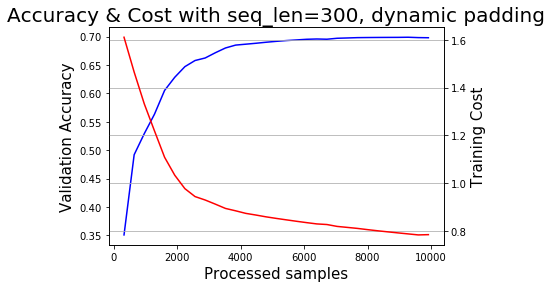

In [23]:
fig, ax1 = plt.subplots()
plt.plot(samples_val, accs_val, 'b-')
ax1.set_ylabel('Validation Accuracy', fontsize=15)
ax1.set_xlabel('Processed samples', fontsize=15)
plt.title('Accuracy & Cost with seq_len=300, dynamic padding', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(samples_val, costs, 'r-')
ax2.set_ylabel('Training Cost', fontsize=15)
plt.grid('on')
plt.savefig("out.png")
plt.show()

In [ ]:
# samples_30, accs_30, costs_30 = [], [], []
# with open("feat66_len30.txt","r") as f:
#     for line in f:
#         line = line.split(',')
#         samples_30.append(line[0])
#         accs_30.append(line[1])
#         costs_30.append(line[2])

157


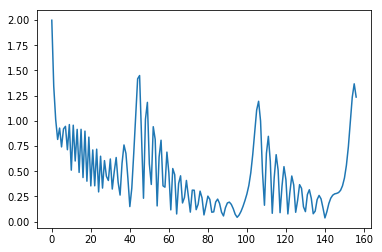

In [24]:
print(len(grads_norm))
plt.plot(np.arange(len(grads_norm)), grads_norm)
plt.show()

In [25]:
with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    new_saver = tf.train.import_meta_graph('bi_gru_300_dp.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored")
    start = time.time()
    acc_test, loss_test = sequential_evaluate(test_list)
    print("finished in {:.1f} seconds".format(time.time() - start))
    print("Accuracy: {}; loss: {}".format(acc_test, loss_test))

INFO:tensorflow:Restoring parameters from ./bi_gru_300_dp
Model restored
Number of processed proteins 0
Snapshot: Accuracy: 0.639143730887; loss: 1.02431368828
Number of processed proteins 100
Snapshot: Accuracy: 0.675151573477; loss: 91.1280678213
Number of processed proteins 200
Snapshot: Accuracy: 0.684041739645; loss: 172.672576986
Number of processed proteins 300
Snapshot: Accuracy: 0.696444371621; loss: 249.707368888
Number of processed proteins 400
Snapshot: Accuracy: 0.6989974353; loss: 333.609347202
Number of processed proteins 500
Snapshot: Accuracy: 0.699499296654; loss: 415.859729014
Number of processed proteins 600
Snapshot: Accuracy: 0.701005232491; loss: 493.535957105
Number of processed proteins 700
Snapshot: Accuracy: 0.703027414256; loss: 568.45912721
Number of processed proteins 800
Snapshot: Accuracy: 0.702361379609; loss: 649.544061504
Number of processed proteins 900
Snapshot: Accuracy: 0.701390638119; loss: 733.343179531
Number of processed proteins 1000
Snapshot

In [ ]:
relative_path = './data/CASP11/'
CASP11_addr = relative_path + 'proteinList'
CASP11_list = read_list(CASP11_addr)
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('bi_gru_300_dp.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model restored")
    start = time.time()
    acc_11, loss_11 = sequential_evaluate(CASP11_list)
    print("finished in {:.1f} seconds", time.time() - start)
    print("Accuracy: {}; loss: {}".format(acc_11, loss_11))